In [ ]:
!pip install -q transformers torchvision pdf2image PyMuPDF beautifulsoup4 requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 857.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 78.0 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image
import requests
from io import BytesIO
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from pdf2image import convert_from_path
import fitz  # PyMuPDF
import time
from transformers import CLIPProcessor, CLIPModel
from IPython.display import display

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
def download_image(url):
    try:
        response = requests.get(url, timeout=15)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    except:
        return None

def extract_images_from_url(web_url, max_images=20):
    print(f"🔗 Extracting images from: {web_url}")
    soup = BeautifulSoup(requests.get(web_url).text, 'html.parser')
    images = []
    for tag in soup.find_all("img"):
        src = tag.get("src")
        if src:
            img_url = urljoin(web_url, src)
            img = download_image(img_url)
            if img:
                images.append(img)
    return images

def extract_images_from_pdf(pdf_path):
    print(f"📄 Extracting images from PDF: {pdf_path}")
    return convert_from_path(pdf_path, dpi=200)

In [ ]:
def classify_images(images, batch_size=5):
    results = []
    start_time = time.time()
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        inputs = processor(text=["medical image", "non-medical image"], images=batch, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1).tolist()
        for p in probs:
            label = "medical" if p[0] > p[1] else "non-medical"
            results.append((label, p))
    total_time = time.time() - start_time
    return results, total_time

In [ ]:
def run_pipeline(input_path_or_url):
    if input_path_or_url.endswith(".pdf"):
        images = extract_images_from_pdf(input_path_or_url)
    elif input_path_or_url.startswith("http"):
        images = extract_images_from_url(input_path_or_url)
    else:
        raise ValueError("Input must be a valid URL or a PDF file path.")

    print(f"🖼️ Total images extracted: {len(images)}")

    results, inference_time = classify_images(images)

    for idx, (label, probs) in enumerate(results):
        print(f"Image {idx+1}: {label.upper()} (Confidence: {probs})")
        display(images[idx])

    print(f"\n⏱️ Total inference time: {inference_time:.2f} seconds")

🔗 Extracting images from: https://www.healthline.com/
🖼️ Total images extracted: 15
Image 1: MEDICAL (Confidence: [0.7354902625083923, 0.26450973749160767])


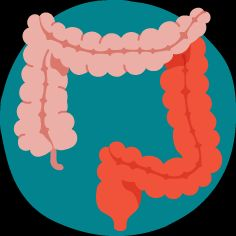

Image 2: NON-MEDICAL (Confidence: [0.4562801122665405, 0.5437198877334595])


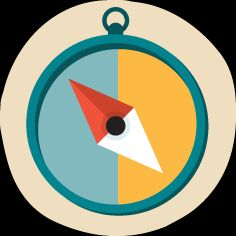

Image 3: MEDICAL (Confidence: [0.575391411781311, 0.42460864782333374])


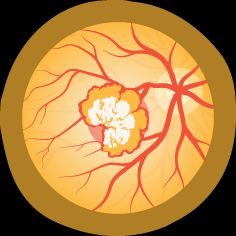

Image 4: MEDICAL (Confidence: [0.518869936466217, 0.4811299741268158])


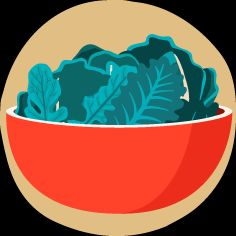

Image 5: MEDICAL (Confidence: [0.5391249060630798, 0.4608750641345978])


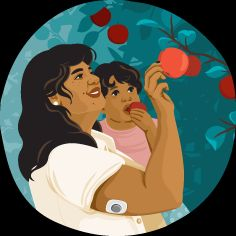

Image 6: NON-MEDICAL (Confidence: [0.4310377538204193, 0.5689622163772583])


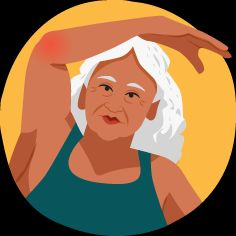

Image 7: MEDICAL (Confidence: [0.5057051181793213, 0.4942949116230011])


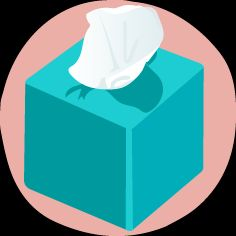

Image 8: NON-MEDICAL (Confidence: [0.12150587141513824, 0.878494143486023])


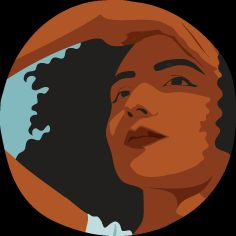

Image 9: NON-MEDICAL (Confidence: [0.31184419989585876, 0.6881557703018188])


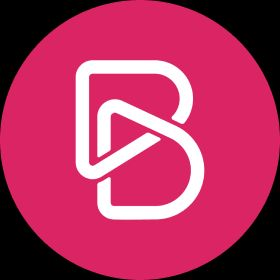

Image 10: NON-MEDICAL (Confidence: [0.2813878655433655, 0.7186121344566345])


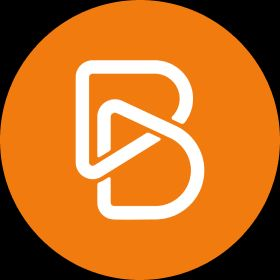

Image 11: NON-MEDICAL (Confidence: [0.49554359912872314, 0.5044564008712769])


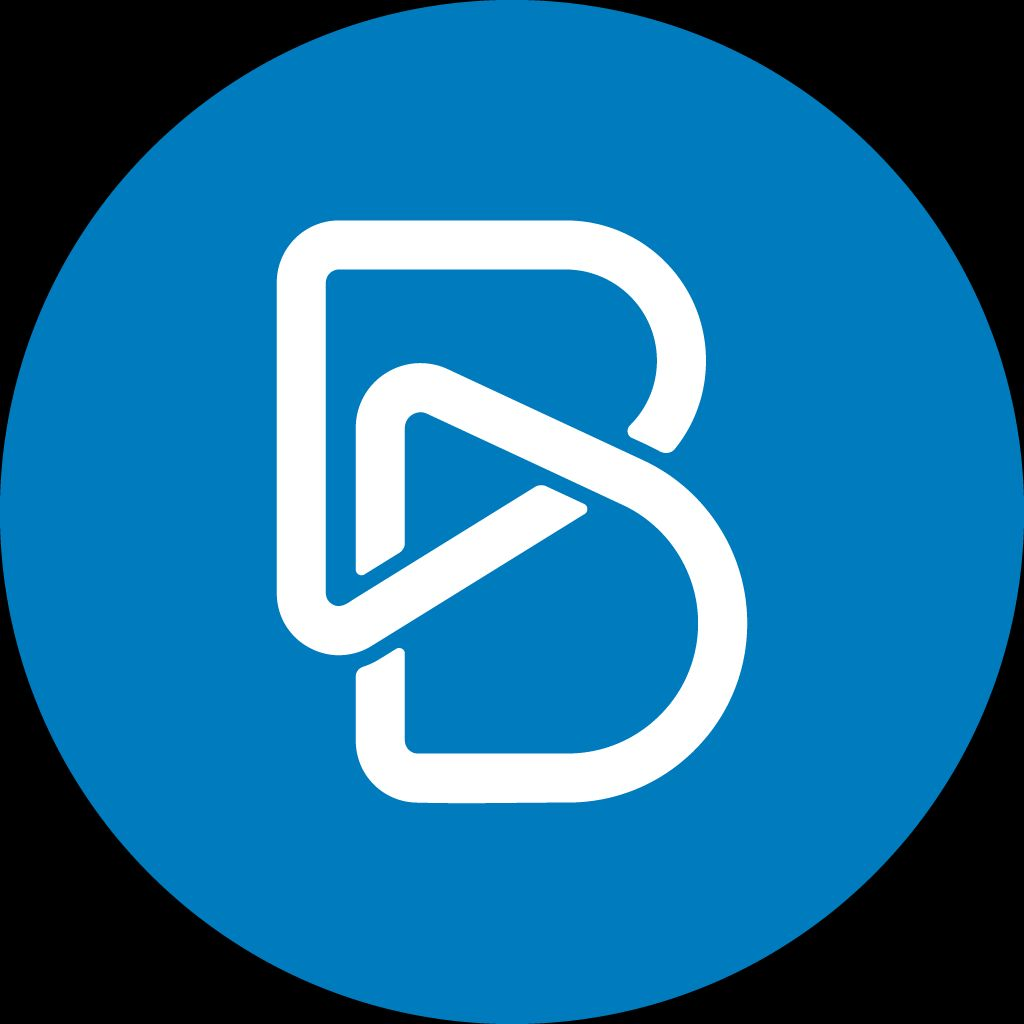

Image 12: MEDICAL (Confidence: [0.515142560005188, 0.4848574101924896])


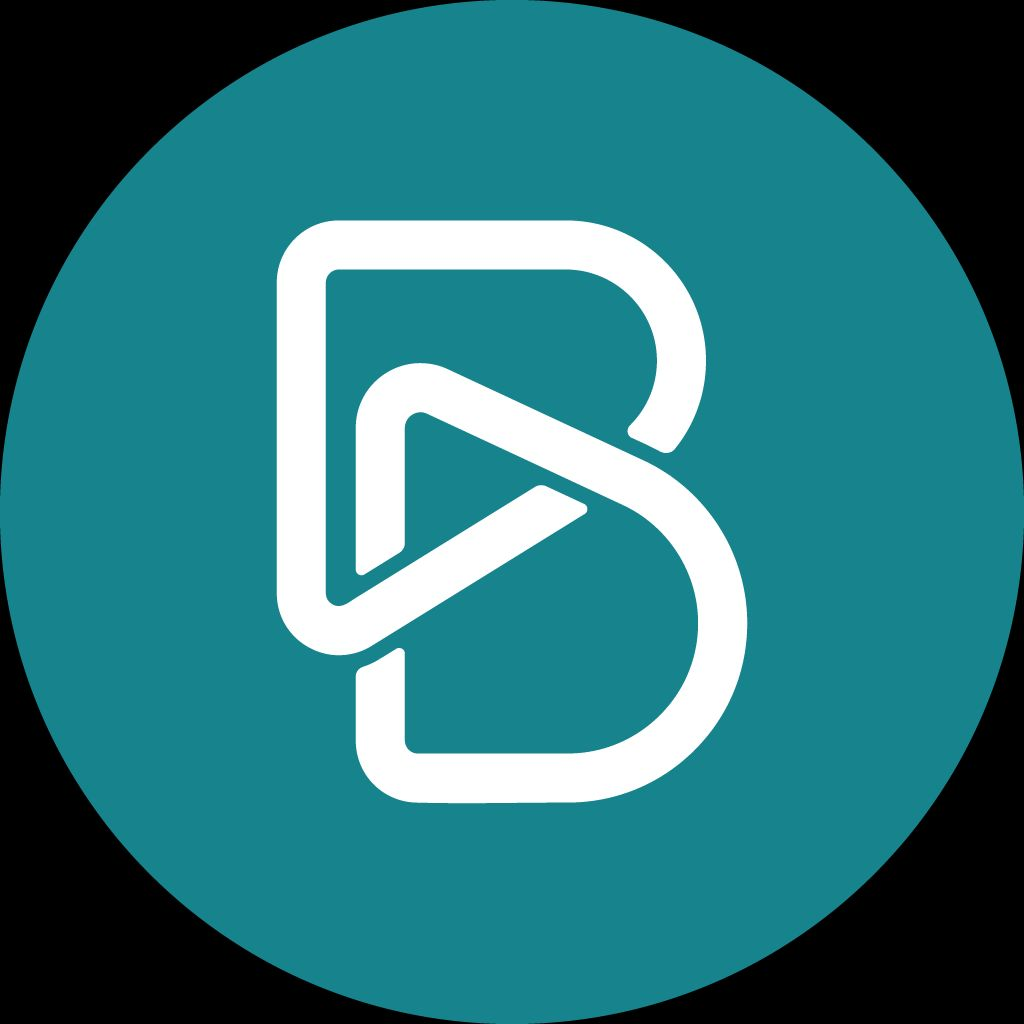

Image 13: NON-MEDICAL (Confidence: [0.29572781920433044, 0.7042721509933472])


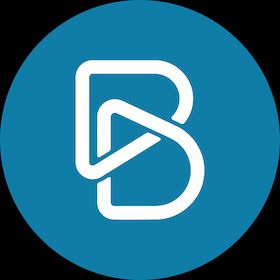

Image 14: NON-MEDICAL (Confidence: [0.3222697079181671, 0.6777302622795105])


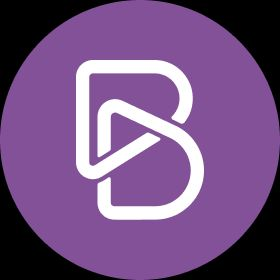

Image 15: NON-MEDICAL (Confidence: [0.3878574073314667, 0.6121425628662109])



⏱️ Total inference time: 5.14 seconds


In [ ]:
run_pipeline("https://www.healthline.com/")

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# pdf_path = list(uploaded.keys())[0]
# run_pipeline(pdf_path)